# Homework part I

The first problem set contains basic tasks in PyTorch.

__Note:__ Instead of doing this part of homework, you can prove your skills otherwise:
* A commit to PyTorch or PyTorch-based repos will do;
* Fully implemented seminar assignment in tensorflow or theano will do;
* Your own project in PyTorch that is developed to a state in which a normal human can understand and appreciate what it does.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torch.nn.functional as F
print(torch.__version__)

1.10.1+cu102


### Task I - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 The Cannabola__
[(_disclaimer_)](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

In [2]:
theta = torch.linspace(-np.pi, np.pi, steps=1000)

<IPython.core.display.Javascript object>


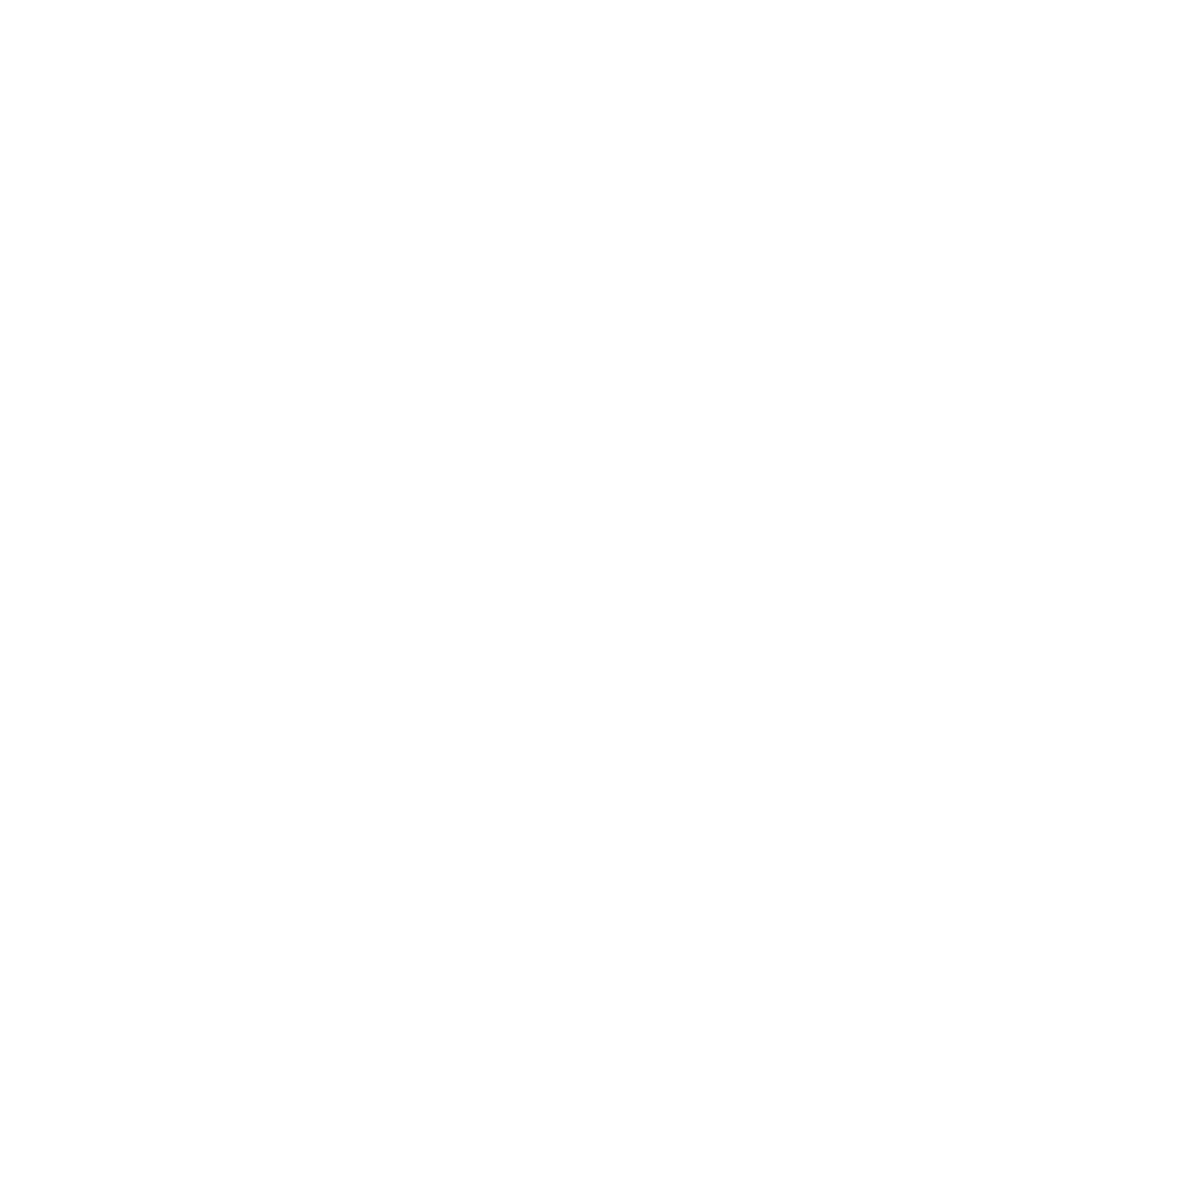

In [3]:
# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * (1 + 0.1 * torch.cos(24 * theta)) * \
    (0.9 + 0.05 * torch.cos(200 * theta)) * (1 + torch.sin(theta))

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = rho * torch.cos(theta)
y = rho * torch.sin(theta) 


plt.figure(figsize=[6, 6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: The Game of Life

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure PyTorch_.

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU!__ Indeed, what could be a better use of your GPU than simulating Game of Life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the URL above out of sloth, here's the Game of Life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference NumPy implementation that you must convert to PyTorch.
_[NumPy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format.

__Note 2:__ From the mathematical standpoint, PyTorch convolution is actually cross-correlation. Those two are very similar operations. More info: [video tutorial](https://www.youtube.com/watch?v=C3EEy8adxvc), [scipy functions review](http://programmerz.ru/questions/26903/2d-convolution-in-python-similar-to-matlabs-conv2-question), [stack overflow source](https://stackoverflow.com/questions/31139977/comparing-matlabs-conv2-with-scipys-convolve2d).

In [4]:
from scipy.signal import correlate2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1, 1, 1],
                        [1, 0, 1],
                        [1, 1, 1]])

    N = correlate2d(Z, filters, mode='same')

    # Apply rules
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z

In [5]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    filters = torch.FloatTensor([[1, 1, 1],
                                 [1, 0, 1],
                                 [1, 1, 1]])
    
    N = F.conv2d(Z[None][None], filters[None][None], padding='same')
    
    birth = (N == 3) & (Z == 0)
    survive = ((N == 2) | (N == 3)) & (Z == 1)

    Z[:] = birth | survive
    return Z


In [6]:
# initial frame
Z_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

# your debug polygon :)
Z_new = torch_update(Z.clone())

# tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), \
    "your PyTorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


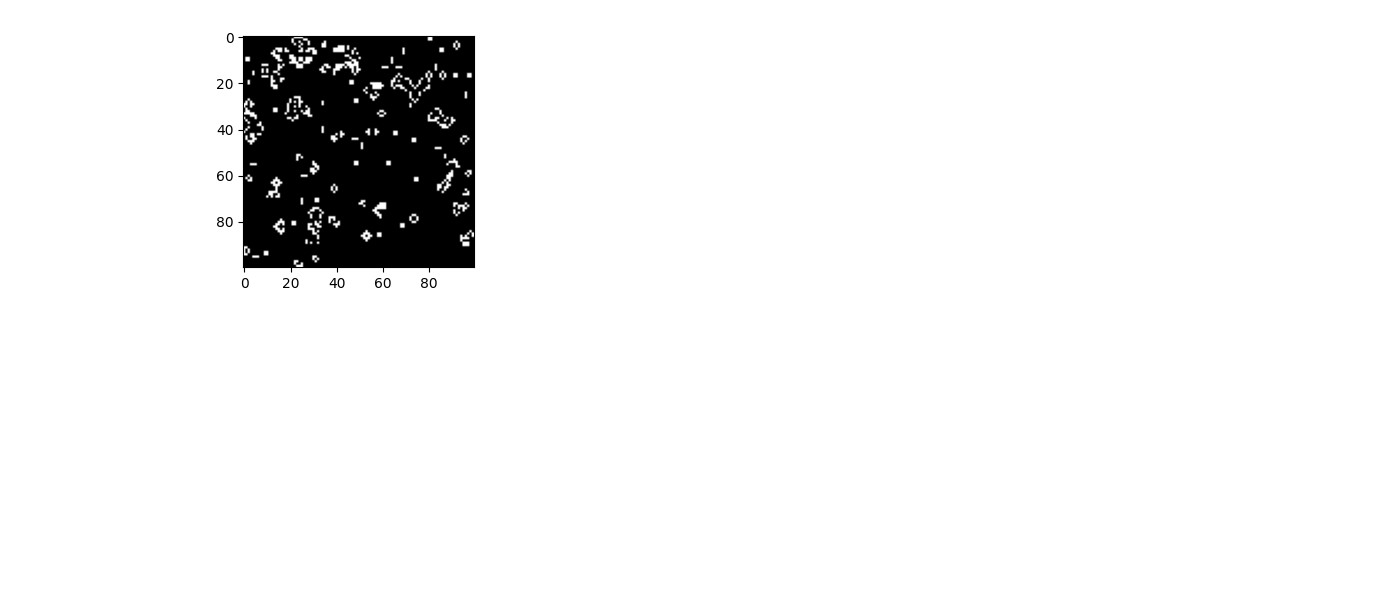

In [7]:
%matplotlib notebook
plt.ion()
# initialize game field
Z = np.random.choice([0, 1], size=(100, 100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig, ax = plt.subplots(1, 1, figsize=(7, 3))
fig.show()
for _ in range(100):
    # update
    Z = torch_update(Z)

    # re-draw image
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    ax.size = (10, 4)
    fig.canvas.draw()
    fig.show()

<IPython.core.display.Javascript object>


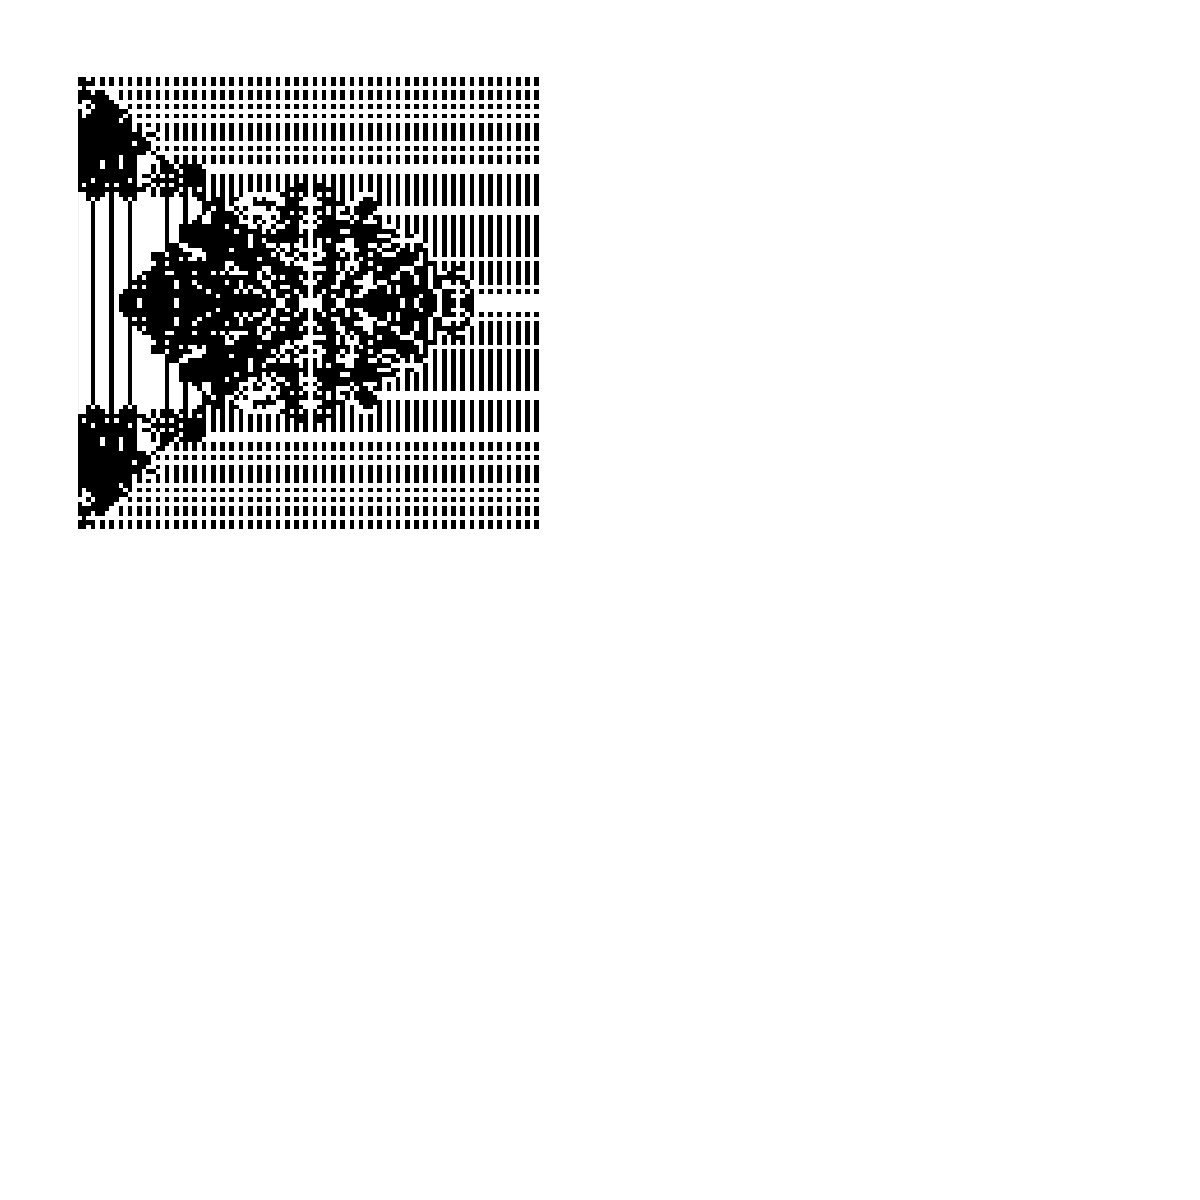

In [8]:
# Some fun setups for your amusement

# parallel stripes
Z = np.arange(100) % 2 + np.zeros([100, 100])
# with a small imperfection
Z[48:52, 50] = 1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fig.show()

In [9]:
for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE) and/or [Jupyter Notebook](https://nbviewer.jupyter.org/url/norvig.com/ipython/Life.ipynb)

### Task III: Going deeper
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>

Your third trial is to build your first neural network [almost] from scratch and pure PyTorch.

This time you will solve yet another digit recognition problem, but at a greater scale

* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression.


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train using __categorical crossentropy__  (see [here](http://wiki.fast.ai/index.php/Log_Loss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors.
If you feel confident enough, just start coding right away and get there ~~if~~ once you need to untangle yourself.

In [10]:
# !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall21/week02_autodiff/notmnist.py

In [433]:
from notmnist import load_notmnist

letters ='ABCDEFGHIJ'
X_train, y_train, X_test, y_test = load_notmnist(letters=letters)
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

Parsing...
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done


In [434]:
def plot_letters(dataset):
    row = int((len(dataset[0]) / 2) ** .5)
    plt.figure(figsize=[12, 3 * row])
    for i, (X, y) in enumerate(zip(*dataset)):
        plt.subplot(row, (len(dataset[0]) + 1) // row, i + 1)
        plt.imshow(X.reshape([28, 28]))
        plt.title(letters[y], fontdict={'fontsize': 20})
        plt.xticks([])
        plt.yticks([])
    plt.show()

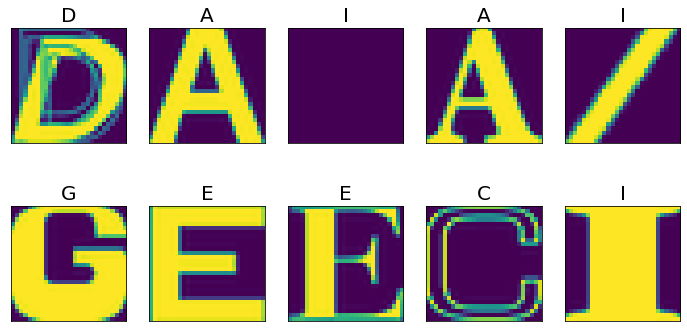

In [435]:
plot_letters(train_data[:10])

In [436]:
from torch.utils.data import DataLoader, TensorDataset

In [437]:
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

In [438]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [439]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [440]:
class NeuralNetwork(nn.Module):
    def __init__(self, layer_sizes):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            *(nn.ReLU() if i % 2 else nn.Linear(layer_sizes[i // 2], layer_sizes[i // 2 + 1])
              for i in range(2 * len(layer_sizes) - 3))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [441]:
def train(dataloader, model, loss_fn, optimizer):
    
    # Switch to training mode
    model.train()
    
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [442]:
@torch.inference_mode()
def test(dataloader, model, loss_fn):
    
    # Switch to evaluation mode
    model.eval()
    
    test_loss = []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        
        with torch.no_grad():
            pred = model(X)
        loss = loss_fn(pred, y)
        loss = loss.item()
        test_loss.append(loss)
        
    return sum(test_loss) / len(test_loss) if test_loss else 0.

In [443]:
def accuracy(pred, y):
    pred = pred.argmax(dim=1)
    return (pred == y).float().mean()

In [444]:
from tqdm import tqdm
import time

class Trainer:
    def __init__(self, name, model, train, test, loss_fn, stats):
        self.name = name
        self.model = model
        self.train = train
        self.test = test
        self.loss_fn = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
        self.stats = stats + [self.loss_fn]
        self.logs = [[] for _ in self.stats]
        self.average_time = 1.

    def run(self, epochs):
        for epoch in range(epochs):
            now = time.time()
            self.train(self.model, self.loss_fn, self.optimizer)
            self.average_time = (self.average_time + time.time() - now) * .5
            plt.figure(figsize=[6, 6])            
            plt.title(f'{self.name}, epoch {epoch + 1} / {epochs}, '
                      f'time left: {self.average_time * (epochs - epoch - 1):.2f} sec')
            plt.xlabel('epoch')
            for stat, log in zip(self.stats, self.logs):
                log.append(self.test(self.model, stat))
                plt.plot(log, label=f"{stat.__name__ if hasattr(stat, '__name__') else str(stat)} - {log[-1]:.3f}")

            plt.legend(loc='best')
            plt.grid()
            plt.show()
            clear_output(wait=True)

In [445]:
my_model = NeuralNetwork([28*28, 1024, len(letters)]).to(device)
trainer = Trainer('2 Layer nn with Relu',
                  my_model,
                  lambda *args: train(train_dataloader, *args),
                  lambda *args: test(test_dataloader, *args),
                  loss_fn,
                  [accuracy]
                 )

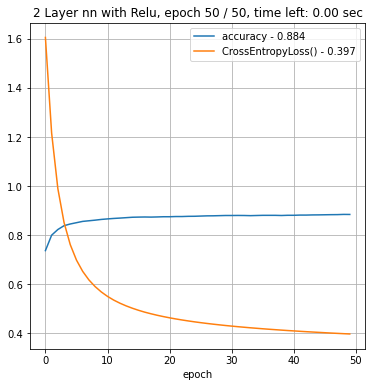

In [446]:
trainer.run(50)

In [469]:
def plot_wrong_letters_util(dataset, predictions):
    row = int((len(dataset[0]) / 2 + 1) ** .5)
    plt.figure(figsize=[12, 3 * row])
    for i, (X, y, pred) in enumerate(zip(*dataset, predictions)):
        plt.subplot(row, (len(dataset[0]) + 1) // row, i + 1)
        plt.imshow(X.reshape([28, 28]))
        plt.title(f"{letters[y]}, predicted {letters[pred]}", fontdict={'fontsize': 14})
        plt.xticks([])
        plt.yticks([])
    plt.show()

def plot_wrong_letters(model):
    batch = next(iter(train_dataloader))
    model.eval()
    with torch.no_grad():
        pred = model(batch[0].to(device))
    pred = pred.argmax(1).to('cpu')
    mask = batch[1] != pred
    plot_wrong_letters_util([batch[0][mask], batch[1][mask]], pred[mask])

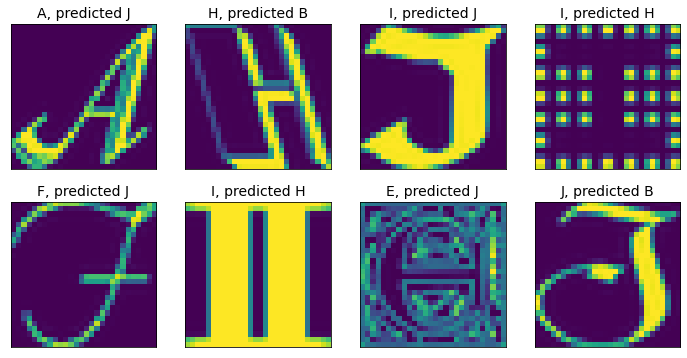

In [475]:
plot_wrong_letters(my_model)

In [449]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = self.linear(x)
        return outputs

logreg = LogisticRegression(X_train[0].size, len(letters)).to(device)
print(logreg)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=10, bias=True)
)


In [450]:
logreg = LogisticRegression(X_train[0].size, len(letters)).to(device)
trainer_lr = Trainer('LogReg',
                  logreg,
                  lambda *args: train(train_dataloader, *args),
                  lambda *args: test(test_dataloader, *args),
                  loss_fn,
                  [accuracy]
                 )

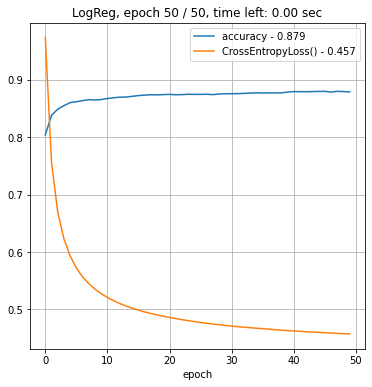

In [451]:
trainer_lr.run(50)

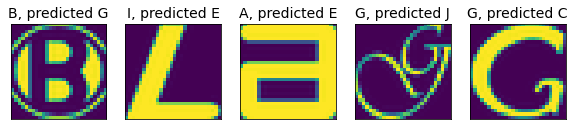

In [476]:
plot_wrong_letters(logreg)

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

# SPOILERS!

Recommended pipeline:

* Adapt logistic regression from seminar assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - Softmax (exp over sum of exps) can be implemented manually or as `nn.Softmax` (layer) or `F.softmax` (function)
  - Probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - You can also try momentum/rmsprop/adawhatever
    - in which case the dataset should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just the output layer :)
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
  - In ideal case this totals to 2 `torch.matmul`'s, 1 softmax and 1 ReLU/sigmoid
  - __Make sure this neural network works better than logistic regression!__

* Now's the time to try improving the network. Consider layers (size, neuron count), nonlinearities, optimization methods, initialization — whatever you want, but please avoid convolutions for now.

* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate $\log P(y \mid x)$ as `F.log_softmax(layer_before_softmax)`.